## Inits

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
model_dir = '/Users/gfg/projects/daas-markdown/res/models/'

## Helpers

In [3]:
def get_best_err(err_df):
    n_row = err_df.shape[0]
    idx = np.arange(0, n_row, step=5)
    best_err = err_df.iloc[idx].copy()
    return best_err

def range_str(t):
    return '(' + str(t[0]) + ',' + str(t[1]) + ']'

def mk_bin_labels(limits):
    lb, ub = limits[:-1], limits[1:]
    labels = [range_str(t) for t in list(zip(lb, ub))]
    return labels

def quant_bin(col, df):
    return [int(df[col].quantile(q)) for q in [0., .25, .50, .75, 1.]]

def cut_to_bins(col, df, limits=None):
    if not limits: # use quart-iles as default
        limits = quant_bin(col, df)
    
    labels = mk_bin_labels(limits)
    binned = df.copy()
    values = pd.cut(binned[col], bins=limits, labels=labels)
    binned['bin_{}'.format(col)] = pd.Categorical(values, categories=labels)
    return binned, labels

In [30]:
def my_plot(df, factor, labels=None, title=None):
    fig, ax = plt.subplots(figsize=(8,5))
#     fig.set_size_inches(11.7, 8.27) # the size of A4 paper
    if labels:
        sns.pointplot(ax=ax, x='bin_n_config', y='test_medape', hue=factor, data=df, order=labels)
    else:
        sns.pointplot(ax=ax, x='bin_n_config', y='test_medape', hue=factor, data=df)
    
    ax.set(xlabel='Group size (no. of SKU configs)', ylabel='MEDian Absolute Percentage Error (MEDAPE)')
    if title:
        ax.set(title=title)
    return fig

__Note:__: if use `sns.factorplot()` will get the issue of a redundant fig is created. Check how to fix the issue (on github?)

In [ ]:
def viz_by_group_size(err_df, title):
    best_err = get_best_err(err_df)
    best_err, labels = cut_to_bins(col='n_config', df=best_err)
    
    my_boxplot(best_err, labels, title)

## Get more group stats

Let us get following stats for test data of each group:
+ min sale, max sale values. The values are daily
+ how far into the future we are making predictions i.e. how far is time window of test set apart from train set (measured later)

In [ ]:
import os
res_dir = '/Users/gfg/projects/daas-markdown/res/'

In [ ]:
def is_pred_file(fname):
    return ('_predict.csv' in fname) and ('scaled' not in fname)

In [ ]:
def get_sale_range(fname):
    pred_df = pd.read_csv(res_dir + fname)
    group_name = fname.replace('_predict.csv', '')
    return pd.DataFrame({'min_sale': min(pred_df['n_sold']), 'max_sale': max(pred_df['n_sold']),
                        'avg_sale': np.mean(pred_df['n_sold']), 'median_sale': np.median(pred_df['n_sold'])
                        }, 
                       index=[group_name])

In [ ]:
f = os.listdir(res_dir)[3]
# print(f)
if is_pred_file(f):
    res = get_sale_range(f)
res

In [ ]:
frames = [get_sale_range(f) for f in os.listdir(res_dir) if is_pred_file(f)]
sale_stats = pd.concat(frames)
sale_stats = sale_stats.reset_index().rename(columns={'index': 'group'})

# DP with original features

In [ ]:
best_err = get_best_err(err_df)
df = best_err.query('n_config >= 70')

cols = ['test_medape', 'n_config', 'avg_records_per_config']
df[cols].hist()
plt.show()

__Obs:__ just a few groups have more than 500 configs, even fewer for 1000 configs.

In [ ]:
thres = 1000
print('# groups with at least {0} configs: {1}'.format(thres, sum(df.n_config >= thres)))

## Accuracy vs. average number of records

In [ ]:
# bin no. of records
best_err = cut_to_bins(col='avg_records_per_config', df=best_err)

In [ ]:
sns.boxplot(x='bin_avg_records_per_config', y='test_medape', data=best_err)
plt.xlabel('Avg. number of records per config'); plt.ylabel('MEDian Absolute Percentage Error (MEDAPE)')
plt.savefig(res_dir + 'acc_n_records.pdf')
plt.show()

## Groups with small error?

In [ ]:
# err_quants = [best_err.test_medape.quantile(q) for q in [.25, .5, .75, 1.]]
low = best_err.test_medape.quantile(.25)
small_err_df = best_err[best_err.test_medape <= low]

In [ ]:
cols = ['n_config', 'avg_records_per_config', 'max_sale', 'min_sale']
small_err_df[cols].describe()

In [ ]:
small_err_df

In [ ]:
small_err_df.avg_sale.describe()

## Groups with large error?

In [ ]:
high = best_err.test_medape.quantile(.75)
big_err_df = best_err[best_err.test_medape >= high]

In [ ]:
big_err_df.avg_sale.describe()

In [ ]:
big_err_df[cols].describe()

# Normalized vs. origin features

## Accuracy vs. group size

Accuracy is measured by MEDian Absolute Percentage Error (MEDAPE).

### Data on metrics

In [ ]:
err_df = pd.read_csv(model_dir + 'metrics.csv')
scaled_err_df = pd.read_csv(model_dir + 'metrics_scaled_feat.csv')

best_err1 = get_best_err(err_df)
best_err1['used_features'] = 'original'

best_err2 = get_best_err(scaled_err_df)
best_err2['used_features'] = 'normalized'

best_err = pd.concat([best_err1, best_err2])

In [15]:
binned_err, labels = cut_to_bins(col='n_config', df=best_err)
binned_err.reset_index(drop=True, inplace=True)

In [16]:
binned_err.bin_n_config.head()

0      (69,162]
1      (69,162]
2      (69,162]
3       (38,69]
4    (162,1462]
Name: bin_n_config, dtype: category
Categories (4, object): [(2,38], (38,69], (69,162], (162,1462]]

### First plot

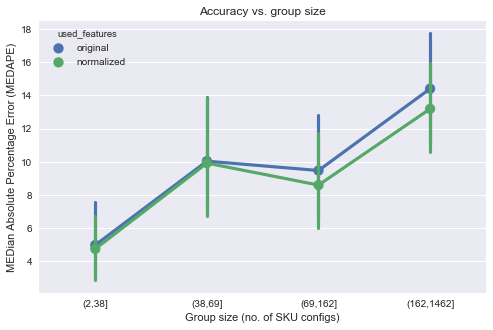

In [17]:
acc_plot = my_plot(df=binned_err, factor='used_features',
              labels=labels, title='Accuracy vs. group size')

The chart reveals that:
+ most groups have MEDAPE less than 10%, except groups with more than 160 SKU configs. Still, 75% of these groups have MEDAPE less than 20%. These are good news.
+ groups with a large number of configs (>= 70) have large variance in MEDAPE. Let us look at them in more details.

### Dive deeper

In [35]:
# groups with size >= 70
sub_df = binned_err.query('n_config >= 70').copy()
sub_df.bin_n_config = sub_df.bin_n_config.cat.remove_unused_categories()

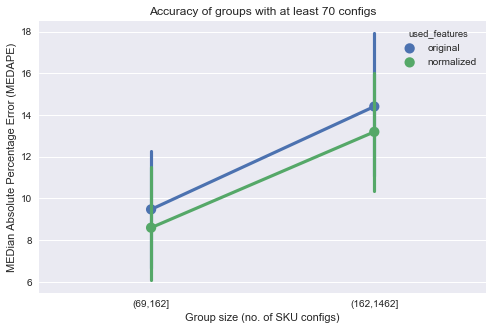

In [36]:
p2 = my_plot(df=sub_df, factor='used_features', title='Accuracy of groups with at least 70 configs')

__Obs:__ largest variance, groups with size from 102 to 118.

In [ ]:
# violin plot
my_factorplot(df=binned_err, factor='used_features', 
              labels=labels, title='Accuracy vs. group size')

In [ ]:
# faceted
sns.factorplot(x='bin_n_config', y='test_medape', data=best_err, 
               col='used_features', order=labels, kind='point')
plt.show()

Where are two last bins?!!

In [ ]:
best_err.shape[0]

In [ ]:
best_err.bin_n_config.value_counts()

In [ ]:
best_err.sort_values(['group'], inplace=True)
best_err.head(6)

In [ ]:
best_err1 = cut_to_bins(col='n_config', df=best_err1)
sns.boxplot(x='bin_n_config', y='test_medape', data=best_err1, order=labels)
plt.show()

In [ ]:
plt.close('all')